# Car Brands and Lift

### Analysis Code

In [19]:
import pandas as pd
import altair as alt
from nltk.corpus import stopwords
from wordcloud import WordCloud
stop_words = set( stopwords.words("english") )

In [2]:
# Helper Func
def text_contains_indicator( text, *args):
    '''Function returns true if all given strings passed in *args
    are present within the text, else returns False'''
    text = text.lower() # lower the text first to get make processing consistent
    
    # Check input that at least 1 word was given in args
    if len(args) == 0:
        print("Error occurred")
        
    if len(args) >= 3:
        print("Error occured in text_contains_indicator\nmore than 2 words passed")
        
    for word in args: # Loop through each arguement
        word = str(word)
        word = word.lower() # lower case the current word to make it consistent with text
        if word not in text:
            return 0
    
    return 1
        
    
def compute_lift(data, text_col, word_1, word_2):
    '''Function to return a numeric value of lift for two given words'''
    
    if word_1 == word_2:
        return 0
    
    data["A"] = data[text_col].map(lambda x: text_contains_indicator(x, word_1))
    data["B"] = data[text_col].map(lambda x: text_contains_indicator(x, word_2))
    data["comentions"] = data[text_col].map(lambda x: text_contains_indicator(x, word_1, word_2))
    
    #print(data)
    
    a_mentions = sum(data["A"])
    b_mentions = sum(data["B"])
    comentions = sum(data["comentions"])
    N = len(data[text_col])
    
    #print(a_mentions)
    #print(b_mentions)
    #print(comentions)
    #print(N)
    
    return (N * comentions) / (a_mentions * b_mentions)

In [3]:
text_df = pd.DataFrame({"text":["Lebron is the best ever", 
                               "Jordan was better in the NBA and in Space Jam",
                               "The NBA isn't the same without Jordan",
                               "Just saw new Space Jam with Lebron, pretty good movie",
                               "Jordan's space jam was waaaay better than Lebrons",
                               "Michael Jordan is the best to ever do it"]})

text_df

,text
0,Lebron is the best ever
1,Jordan was better in the NBA and in Space Jam
2,The NBA isn't the same without Jordan
3,"Just saw new Space Jam with Lebron, pretty goo..."
4,Jordan's space jam was waaaay better than Lebrons
5,Michael Jordan is the best to ever do it


In [4]:
compute_lift(text_df, "text", "Lebron", "Lebron")

0

In [5]:
def get_word_frequencies(data, text_col):
    all_text = ' '.join(text for text in data[text_col])
    
    bow_words = {}
    for word in all_text.split():
        if word in bow_words:
            bow_words[word] += 1 
        else:
            bow_words[word] = 1
            
    df = pd.DataFrame.from_dict(bow_words, orient="index", columns=["Frequency"])#.reset_index()#.rename({"index":"Word"},axis=1)
    return df.reset_index().rename({"index":"Word"},axis=1)


wf_df = get_word_frequencies(text_df, "text")


In [6]:
def find_replace_helper(text, replace_dict):
    for key in replace_dict.keys():
        if key.lower() in text.lower():
            # do replacement
            idx_replace_idx = text.lower().index( key.lower() )
            beg = text[:idx_replace_idx]
            
            end = text[idx_replace_idx + len(key) : ]
            
            text =  beg + replace_dict[key] + end
            
    return text
            
def find_replace(data, text_col, replace_dict):
    '''
    Function to handle find and replace.
    replace_dict should be a dictionary with key equal to original word
    and value equal to replacement
    '''
    data[text_col] = data[text_col].map(lambda x: find_replace_helper(x, replace_dict))
    

test_replace_dict = {"This":"That", "some":"an example", "is":"was"}
    
find_replace_helper("This is some text to do replacement on", test_replace_dict)

'That was an example text to do replacement on'

In [21]:
attributes = ["Jordan", "Lebron", "Space Jam", "NBA"] 

def build_matrix(attributes):

    matrix = {key:[0.0] * len(attributes) for key in attributes}
    matrix["Index"] = attributes
    
    return pd.DataFrame(matrix) 

In [22]:
def lift_main(data, text_col, attributes):
    '''Main function to caluclate lift of all attributes and generate a matrix of lift values'''
    
    matrix = build_matrix(attributes)

    matrix.set_index("Index", inplace=True)
    for row in matrix.index: # iterate through each row
        matrix.loc[row]
        for col in matrix.columns: # iterate through each column 
            matrix.loc[row][col] = compute_lift(text_df, "text", row, col) # assign lift
            
    return matrix

matrix = lift_main(text_df, "text", attributes)
matrix

,Jordan,Lebron,Space Jam,NBA
Index,,,,
Jordan,0.0,0.500000,1.000000,1.5
Lebron,0.5,0.000000,1.333333,0.0
Space Jam,1.0,1.333333,0.000000,1.0
NBA,1.5,0.000000,1.000000,0.0


In [26]:
def dissimilarity_matrix(matrix, no_lift_thresh = 5):
    '''transform a given similarity matrix to a dissimilarity matrix'''
    for col in matrix.columns:
        matrix[col] = matrix[col].map(lambda x: 1 / x if x > 0 else no_lift_thresh)
        
    return matrix
    
matrix = dissimilarity_matrix(matrix)
matrix

,Jordan,Lebron,Space Jam,NBA
Index,,,,
Jordan,5.000000,2.00,1.00,0.666667
Lebron,2.000000,5.00,0.75,5.000000
Space Jam,1.000000,0.75,5.00,1.000000
NBA,0.666667,5.00,1.00,5.000000


<module 'matplotlib.pyplot' from '/Users/samworley/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

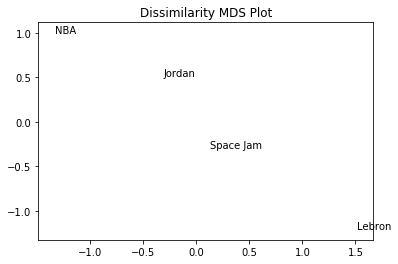

In [27]:
from sklearn import manifold
import matplotlib.pyplot as plt

def generate_MDS_plot(matrix_df):
    mds_model = manifold.MDS(n_components = 2, random_state = 48,
    dissimilarity = "precomputed")

    labels = [str(label) for label in list(matrix_df.index)]

    mds_fit = mds_model.fit(matrix_df)
    coords = mds_fit.embedding_

    plt.figure()
    plt.scatter(coords[:,0], coords[:,1], facecolors = "none")

    for label, x, y in zip(labels, coords[:,0], coords[:,1]):
        plt.annotate(label, (x,y), xycoords = 'data')

    plt.title("Dissimilarity MDS Plot")
    
    return plt

generate_MDS_plot(matrix)

<module 'matplotlib.pyplot' from '/Users/samworley/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

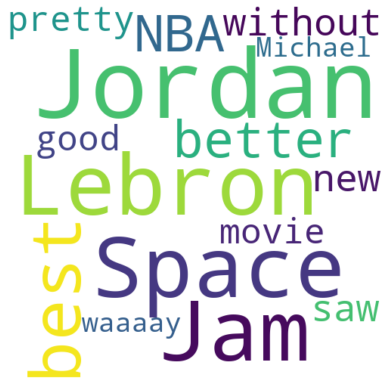

In [20]:
def generate_wordcloud(data, text_col):
    '''TODO'''
    text = ' '.join( data[text_col] ) 
    
    text = ' '.join( [word for word in text.split() if word not in stop_words]) # remove stop words
    
    wc = WordCloud(width=500, height=500, background_color="white").generate(text)

    # display the generated image:
    my_dpi = 72
    plt.figure(figsize = (500/my_dpi, 500/my_dpi), dpi=my_dpi)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    
    return plt


generate_wordcloud(text_df, "text")

